In [375]:

#install required libraries in neccesarily
"""!pip install torch==2.0.0
!pip install numpy==1.26.1
!pip install pandas==2.1.3
!pip install scipy==1.1.1
!pip install matplotlib==3.7.1
!pip install tqdm==4.65.0"""

import numpy as np
import pandas as pd
from scipy.special import lambertw as LW
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


## Download a preprocess data

In [2]:

data = pd.read_csv('HistoricalData_SP500.csv')
#dataset was downloaded from:
#https://www.nasdaq.com/market-activity/index/spx/historical?page=1&rows_per_page=10&timeline=y5
#and has the following columns: Data, 'Close/Last', Open, High, Low
data.rename(columns={'Close/Last': 'Close'}, inplace = True)
data.Date = pd.to_datetime(data.Date, format='%m/%d/%Y')
data.Close = data.Close.astype(float)
data.Open = data.Open.astype(float)


first_day = data.Date.iloc[-1]
last_day =data.Date.iloc[0]

df = data.drop(columns=['Low','High','Open', 'Date'])
df.rename(columns={'Close/Last': 'Close'}, inplace = True)

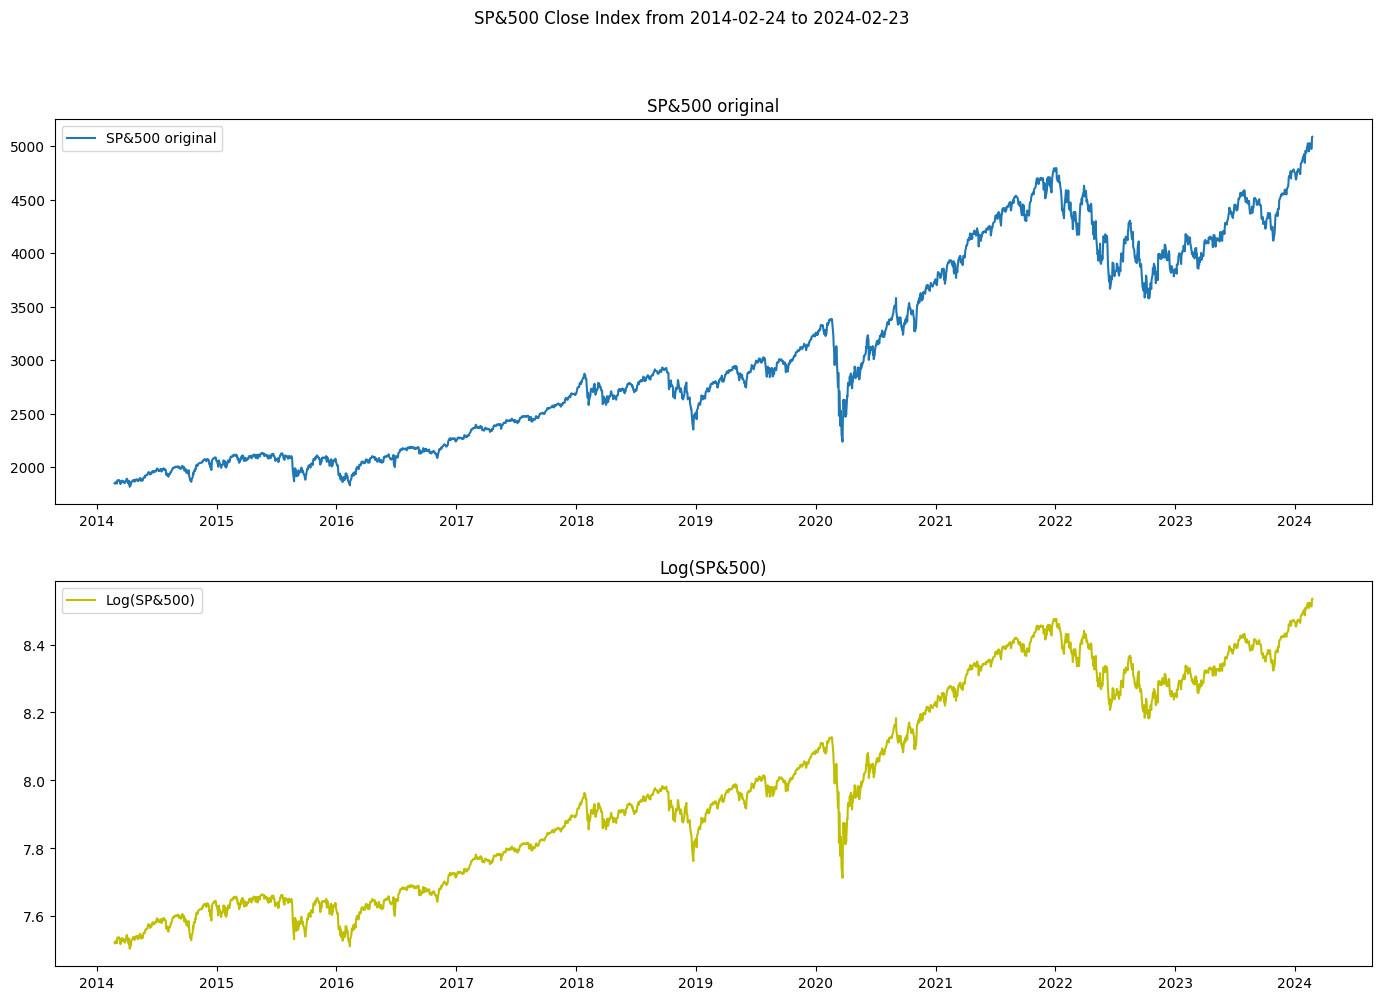

In [3]:
#Visualize original dataset

plt.figure(figsize=(17, 11))
plt.suptitle(f'SP&500 Close Index from {first_day.date()} to {last_day.date()}')
plt.subplot(2,1, 1)
plt.title(f'SP&500 original')
plt.plot(data.Date, data.Close, label = 'SP&500 original')
plt.legend()
plt.subplot(2,1, 2)
plt.title(f'Log(SP&500)')
plt.plot(data.Date, np.log(data.Close), label = 'Log(SP&500)' , color = 'y')
plt.legend()


In [4]:
#Preprocessing of the original data:
#1. Log_return = log(Close_t/Close_t-1)
#2  Normalization 
#3  Reverse LambertW transform
#4  Normalization
#mean and standard diviation are saved. They will be used futher to recover data close to original one

def Transform(df):
    #takes DataFrame as an input with Close values sorted in descending order
    df = df/df.shift(-1)
    df = df.iloc[:-1]
    df = np.log(df)
    mean_1 = df.mean().values[0]
    std_1 = df.std().values[0]
    df = (df - mean_1)/std_1
    df.Close = df.Close.apply(lambda x: np.real(LW(x)) if x >= 0 else -np.real(LW(-x)))
    mean_2 = df.mean().values[0]
    std_2 = df.std().values[0]
    df = (df - mean_2)/std_2
    return df, mean_1, std_1, mean_2, std_2

df, mean_1, std_1, mean_2, std_2 = Transform(df)



In [5]:
def RevTransform(gen_dt, mean_1, std_1, mean_2, std_2, first = 0):
    #takes 3-dim tensor of generated data and transforms it to the original form
    #mean_1, std_1, mean_2, std_2 - learned parameters from the original data transformation
    #first - first element, by defualt Generator doesn't produce it, so it is needed to be specified
    #return log of original data
    array = torch.reshape(gen_dt, (-1, gen_dt.shape[2])).detach().numpy()
    array = std_2*array + mean_2
    array = np.sign(array)*np.abs(array) * np.e**(np.abs(array))
    array = std_1*array + mean_1
    x = first
    
    for i in range(array.shape[1]):
        array[:,i]+=x
        x = array[:,i]    
        
    return np.insert(array, 0, first, 1)

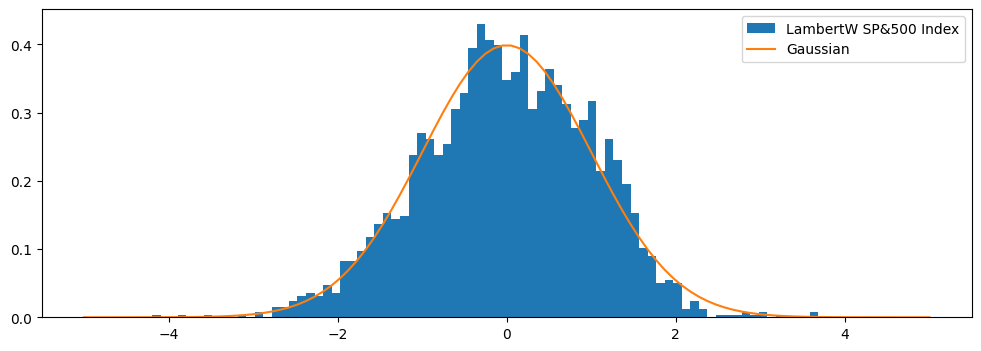

In [383]:
#Compare trnasformed dataset with Gaussian distributiona
x = df.to_numpy().reshape(-1)
#y = [np.random.normal(0,1) for i in range(x.size)]
bins = np.linspace(-5, 5, 100)
gaussian = [norm.pdf(i) for i in bins]
plt.figure(figsize=(12, 4))
plt.hist(x, bins, label='LambertW SP&500 Index', density=True)
#plt.hist(y, bins, histtype = 'step', label = 'Gaussian', density = True)
plt.plot(bins, gaussian, label = 'Gaussian')
plt.legend()
plt.show()

In [7]:
#Transform preprocessed data to numpy fit it to the format (N_samples, N_channels, N_observations)
#and reverse it to ensure, that data samples goes chronologically from left to right. 
#Such an data order is assumed in the training process of GAN
dt_array = df.to_numpy()[::-1].reshape(1, -1).copy()

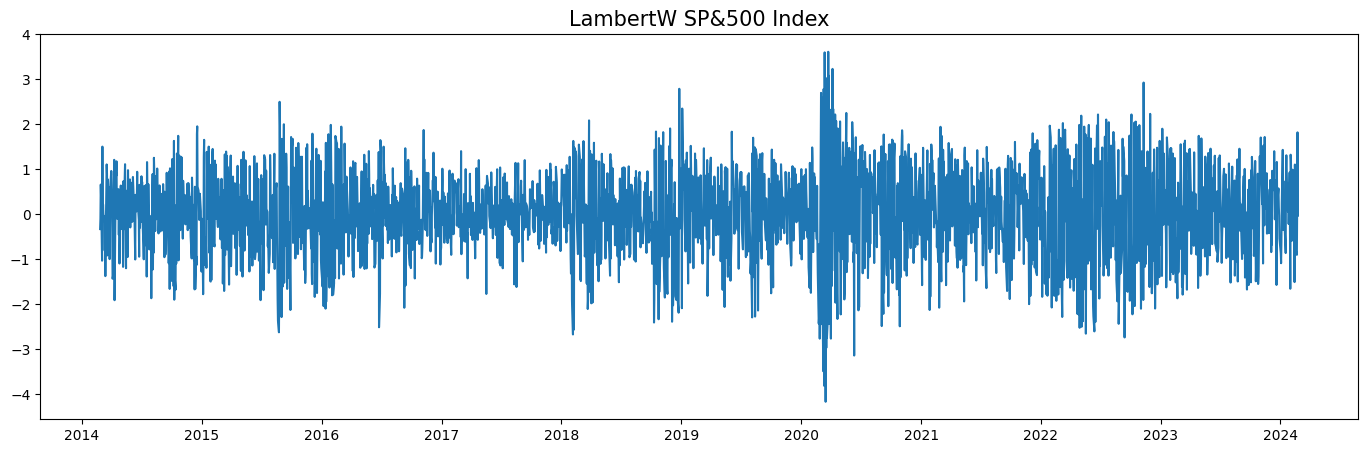

In [8]:
#Visualize transformed dataset

plt.figure(figsize=(17,5))
plt.title(f'LambertW SP&500 Index', fontsize = 15)
x = data.Date.sort_values(ascending=True).to_numpy()[1:]
y = dt_array[0,:]

plt.plot(x, y)
plt.show()

## Generator and Discriminator implementations

In [9]:

#weights initialization according to DCGAN paper
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


class LeftPad(nn.Module):
    #expands vectors in the given batch by adding zeros to their left ends 
    def __init__(self, leftpad):
        super(LeftPad, self).__init__()
        self.leftpad = leftpad
    
    def forward(self, x):

        assert x.dim() == 3, " ndim of input tensor isn't equal 3"
        zeros = torch.zeros(x.shape[0],x.shape[1],self.leftpad)
        result = torch.cat([zeros, x], dim = 2)
        return result.contiguous()

    
class TemporalBlock(nn.Module):
    def __init__(self, input_ch, output_ch, kernel, dilation, init_weights = True):
        super(TemporalBlock, self).__init__()

        self.input_ch = input_ch
        self.hidden_ch = input_ch
        self.output_ch = output_ch
        assert kernel in [1,2], 'kernel size should be equal 1 or 2'
        self.kernel = kernel
        self.stride = 1
        if kernel == 1:
            self.leftpad = 0
        else:
            self.leftpad = dilation
        self.dilation = dilation
        self.leaku_par1 = self.hidden_ch
        self.leaku_par2 = self.output_ch
        self.init_weights = init_weights
        
        
        self.net = nn.Sequential(
            #Perform leftpadding for input tensor to ensure that Conv1d doesnt change sequence lenght 
            #
            # Formula for Conv1d:
            #output_size = (input_size + 2*padding - dilation(kernel-1) -1)/stride + 1
            #
            #In our model stride = 1, padding = 0, thus input_size - output_size = dilations*(kernel-1)
            #Thus to preserve sequence length untouched  n=dilation zeroes are added to the left end of input tensors
            #
            #Leftpadding also introduces required connection structure between nerons, 
            #that neuron n_i(numerations goes from left to right) is connected with 
            #neurons [n_i1, n_i2...n_ik], where ij = n_(i-dilation*(k-j+1)) and ij >=1
           
            LeftPad(self.leftpad),
            nn.Conv1d(self.input_ch, self.hidden_ch, self.kernel, self.stride, 0, self.dilation),
            nn.BatchNorm1d(self.hidden_ch),
            nn.PReLU(self.leaku_par1),
            LeftPad(self.leftpad),
            nn.Conv1d(self.hidden_ch, self.output_ch, self.kernel, self.stride, 0, self.dilation),
            nn.BatchNorm1d(self.output_ch),
            nn.PReLU(self.leaku_par2)
        )
        
        if self.init_weights:
            self.net.apply(weights_init)
   
    def forward(self, x):
        return self.net(x)
        


class Generator(nn.Module):
    def __init__(self, n_ch = 3, init_weights = True):
        super(Generator, self).__init__()
        self.n_ch = n_ch
        self.init_weights = init_weights
        self.main = nn.ModuleList([TemporalBlock(self.n_ch, 80, 1, 1, self.init_weights),
                                  TemporalBlock(80, 80, 2, 1, self.init_weights),
                                  TemporalBlock(80, 80, 2, 2, self.init_weights),
                                  TemporalBlock(80, 80, 2, 4, self.init_weights),
                                  TemporalBlock(80, 80, 2, 8, self.init_weights),
                                  TemporalBlock(80, 80, 2, 16, self.init_weights),
                                  TemporalBlock(80, 80, 2, 32, self.init_weights)
                                 ])
        self.last = nn.Conv1d(80, 1, 1, 1)
        self.down_sampl = nn.Conv1d(self.n_ch, 1, 1, 1)
        if self.init_weights:
            self.last.apply(weights_init)
            self.down_sampl.apply(weights_init)

        
    def forward(self, size, seq_length):
        x = torch.rand(size, self.n_ch, seq_length)
        x_ = self.down_sampl(x)
        skip_list = [x_]
        for layer in self.main:
            x = layer(x)
            skip_list.append(x)
        x = self.last(sum(skip_list))
        return x
        
class Discriminator(nn.Module):
    def __init__(self, seq_length, init_weights = True):
        super(Discriminator, self).__init__()
        self.seq_length = seq_length
        
        self.init_weights = init_weights
        self.main = nn.ModuleList([TemporalBlock(1, 80, 1, 1, self.init_weights),
                                  TemporalBlock(80, 80, 2, 1, self.init_weights),
                                  TemporalBlock(80, 80, 2, 2, self.init_weights),
                                  TemporalBlock(80, 80, 2, 4, self.init_weights),
                                  TemporalBlock(80, 80, 2, 8, self.init_weights),
                                  TemporalBlock(80, 80, 2, 16, self.init_weights),
                                  TemporalBlock(80, 80, 2, 32, self.init_weights)
                                 ])
       
        self.last = nn.Sequential(nn.Conv1d(80, 1, 1, 1),
                                  nn.Linear(self.seq_length, 1),
                                  nn.Sigmoid())
        if self.init_weights:
            self.last.apply(weights_init)
        
    def forward(self, x):
        skip_list = [x]
        for layer in self.main:
            x = layer(x)
            skip_list.append(x)
        x = self.last(sum(skip_list)).squeeze()
        return x
        


In [10]:
#Transform preprocessed data to numpy array of size (-1,1,1) and reverse it to ensure, that data samples
#goes chronologically from left to right. Such an data order is assumed in the training process of GAN
dt_array = df.to_numpy()[::-1].reshape(1, -1).copy()

In [229]:
#Define DataLoader for given data
class DataSet(Dataset):
    def __init__(self, data, seq_length):
        #data - dataset
        #seq_length - number of sequential data points taken to construct one sample
        super(Dataset, self).__init__()
        self.data = data
        self.seq_length = seq_length
        assert self.data.shape[1] >= self.seq_length, f"Input data size < seq_length"
    def __len__(self):
        return self.data.shape[1] - self.seq_length+1

    def __getitem__(self, index):
        return self.data[:, index:index+self.seq_length]


dt_set = DataSet(dt_array, seq_length)


## Vanilla GAN

In [21]:
#If you don't want to waste time on training you can use pretrained G_Vanilla GAN
"""VG_path = r'trained models/Vanilla_GAN_Generator.pth'
VG = Generator()
VG.load_state_dict(torch.load(VG_path))
G = VG"""

In [202]:
#define hyperparameters, initialize Generator, Discriminator and optimizers
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

seq_length = 127 
batch_size = 32
dt_loader = DataLoader(dt_set, batch_size, shuffle=True, drop_last=True)

G_lr = 1e-4
D_lr = 1e-4


G = Generator().to(device)
D = Discriminator(seq_length).to(device) 


G_optm = torch.optim.AdamW(G.parameters(), lr=G_lr)
D_optm = torch.optim.AdamW(D.parameters(), lr=D_lr)

Model_losses = []
G_losses = []
D_losses = []

In [207]:
#Train Vanilla GAN

n_epochs = 10
step_ratio = 1
eps = 1e-15

with tqdm(total=n_epochs*len(dt_loader), desc=f"Progress") as progress:
    for i in range(n_epochs):
        for i, batch in enumerate(dt_loader):
            size = batch.shape[0]
            real_dt = batch.to(device)
            real_dt = batch.to(torch.float32)
            gen_dt = G.forward(size, seq_length).detach()
            D_optm.zero_grad()
            D_l = torch.mean(torch.log(D(real_dt)+eps))
            G_l = torch.mean(torch.log(1-D(gen_dt)+eps))
            Model_l = -(D_l + G_l)
            Model_l.backward()
            D_optm.step()
            D_losses.append(D_l.item())
            Model_losses.append(-Model_l.item())
        
            if (i+1) % step_ratio == 0:
                G_optm.zero_grad()
                gen_dt = G.forward(size, seq_length)
                G_l = -torch.mean(torch.log(D(gen_dt)+eps))
                G_l.backward()
                G_optm.step()
                for j in range(step_ratio):
                    G_losses.append(-G_l.item())
            progress.update()
                

Progress:   0%|          | 0/750 [00:00<?, ?it/s]

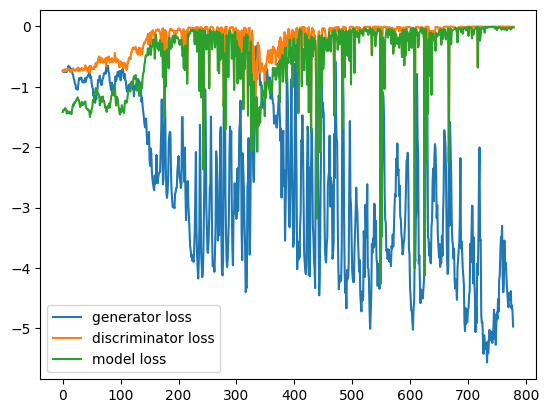

In [208]:
#Plot loss functions for G and D
plt.plot(G_losses, label='generator loss')
plt.plot(D_losses, label='discriminator loss')
plt.plot(Model_losses, label='model loss')
plt.legend()
plt.show()

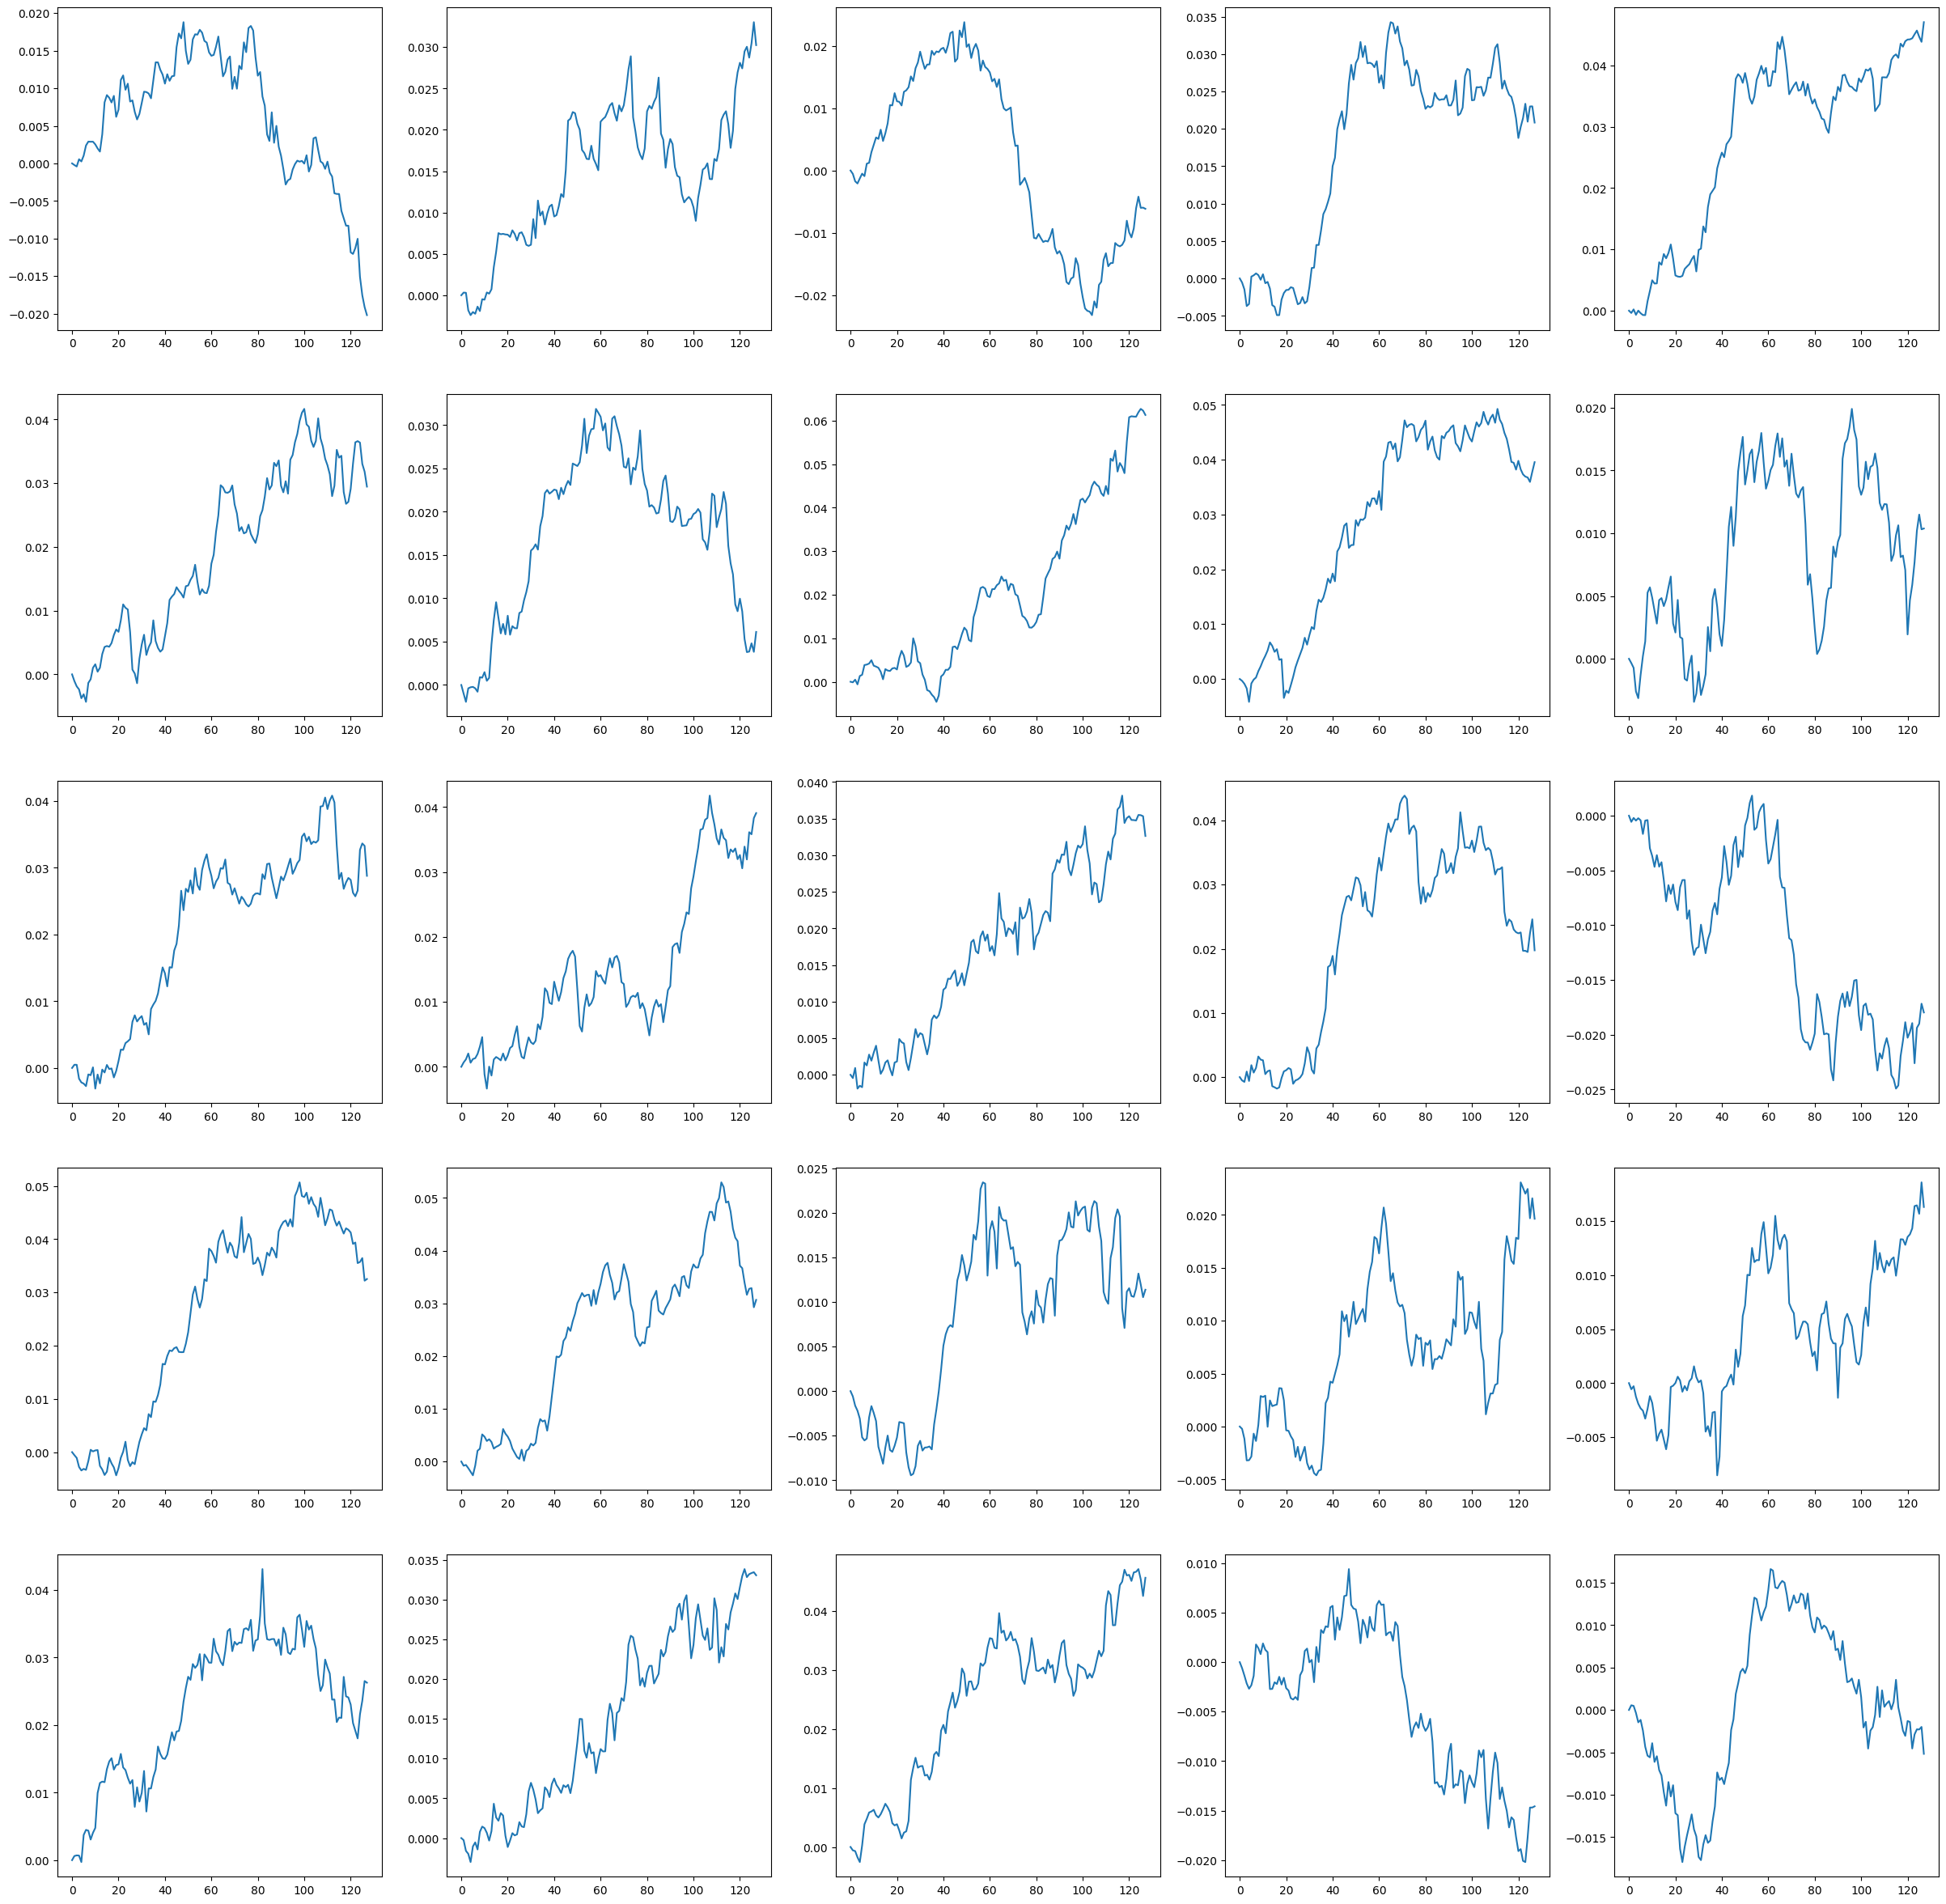

In [219]:
gen_dt = G(25, 127)
rev_trf_dt = RevTransform(gen_dt, mean_1, std_1, mean_2, std_2)

plt.figure(figsize=(30, 30))
for i, dt in enumerate(rev_trf_dt):
    plt.subplot(5, 5, i+1)
    plt.plot(dt)
plt.show()

In [215]:
#save G and D for Vanilla GAN

"""G_path = 'trained models/Vanilla_GAN_G.pth'#enter G name
D_path = 'trained models/Vanilla_GAN_D.pth'#enter D name
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)"""

From the first look Vanilla GAN is able to produce pretty good time-series. But it seems that trained Generator is not better than untrained one. For comparing some time-series of untrained Generator are presented below. 

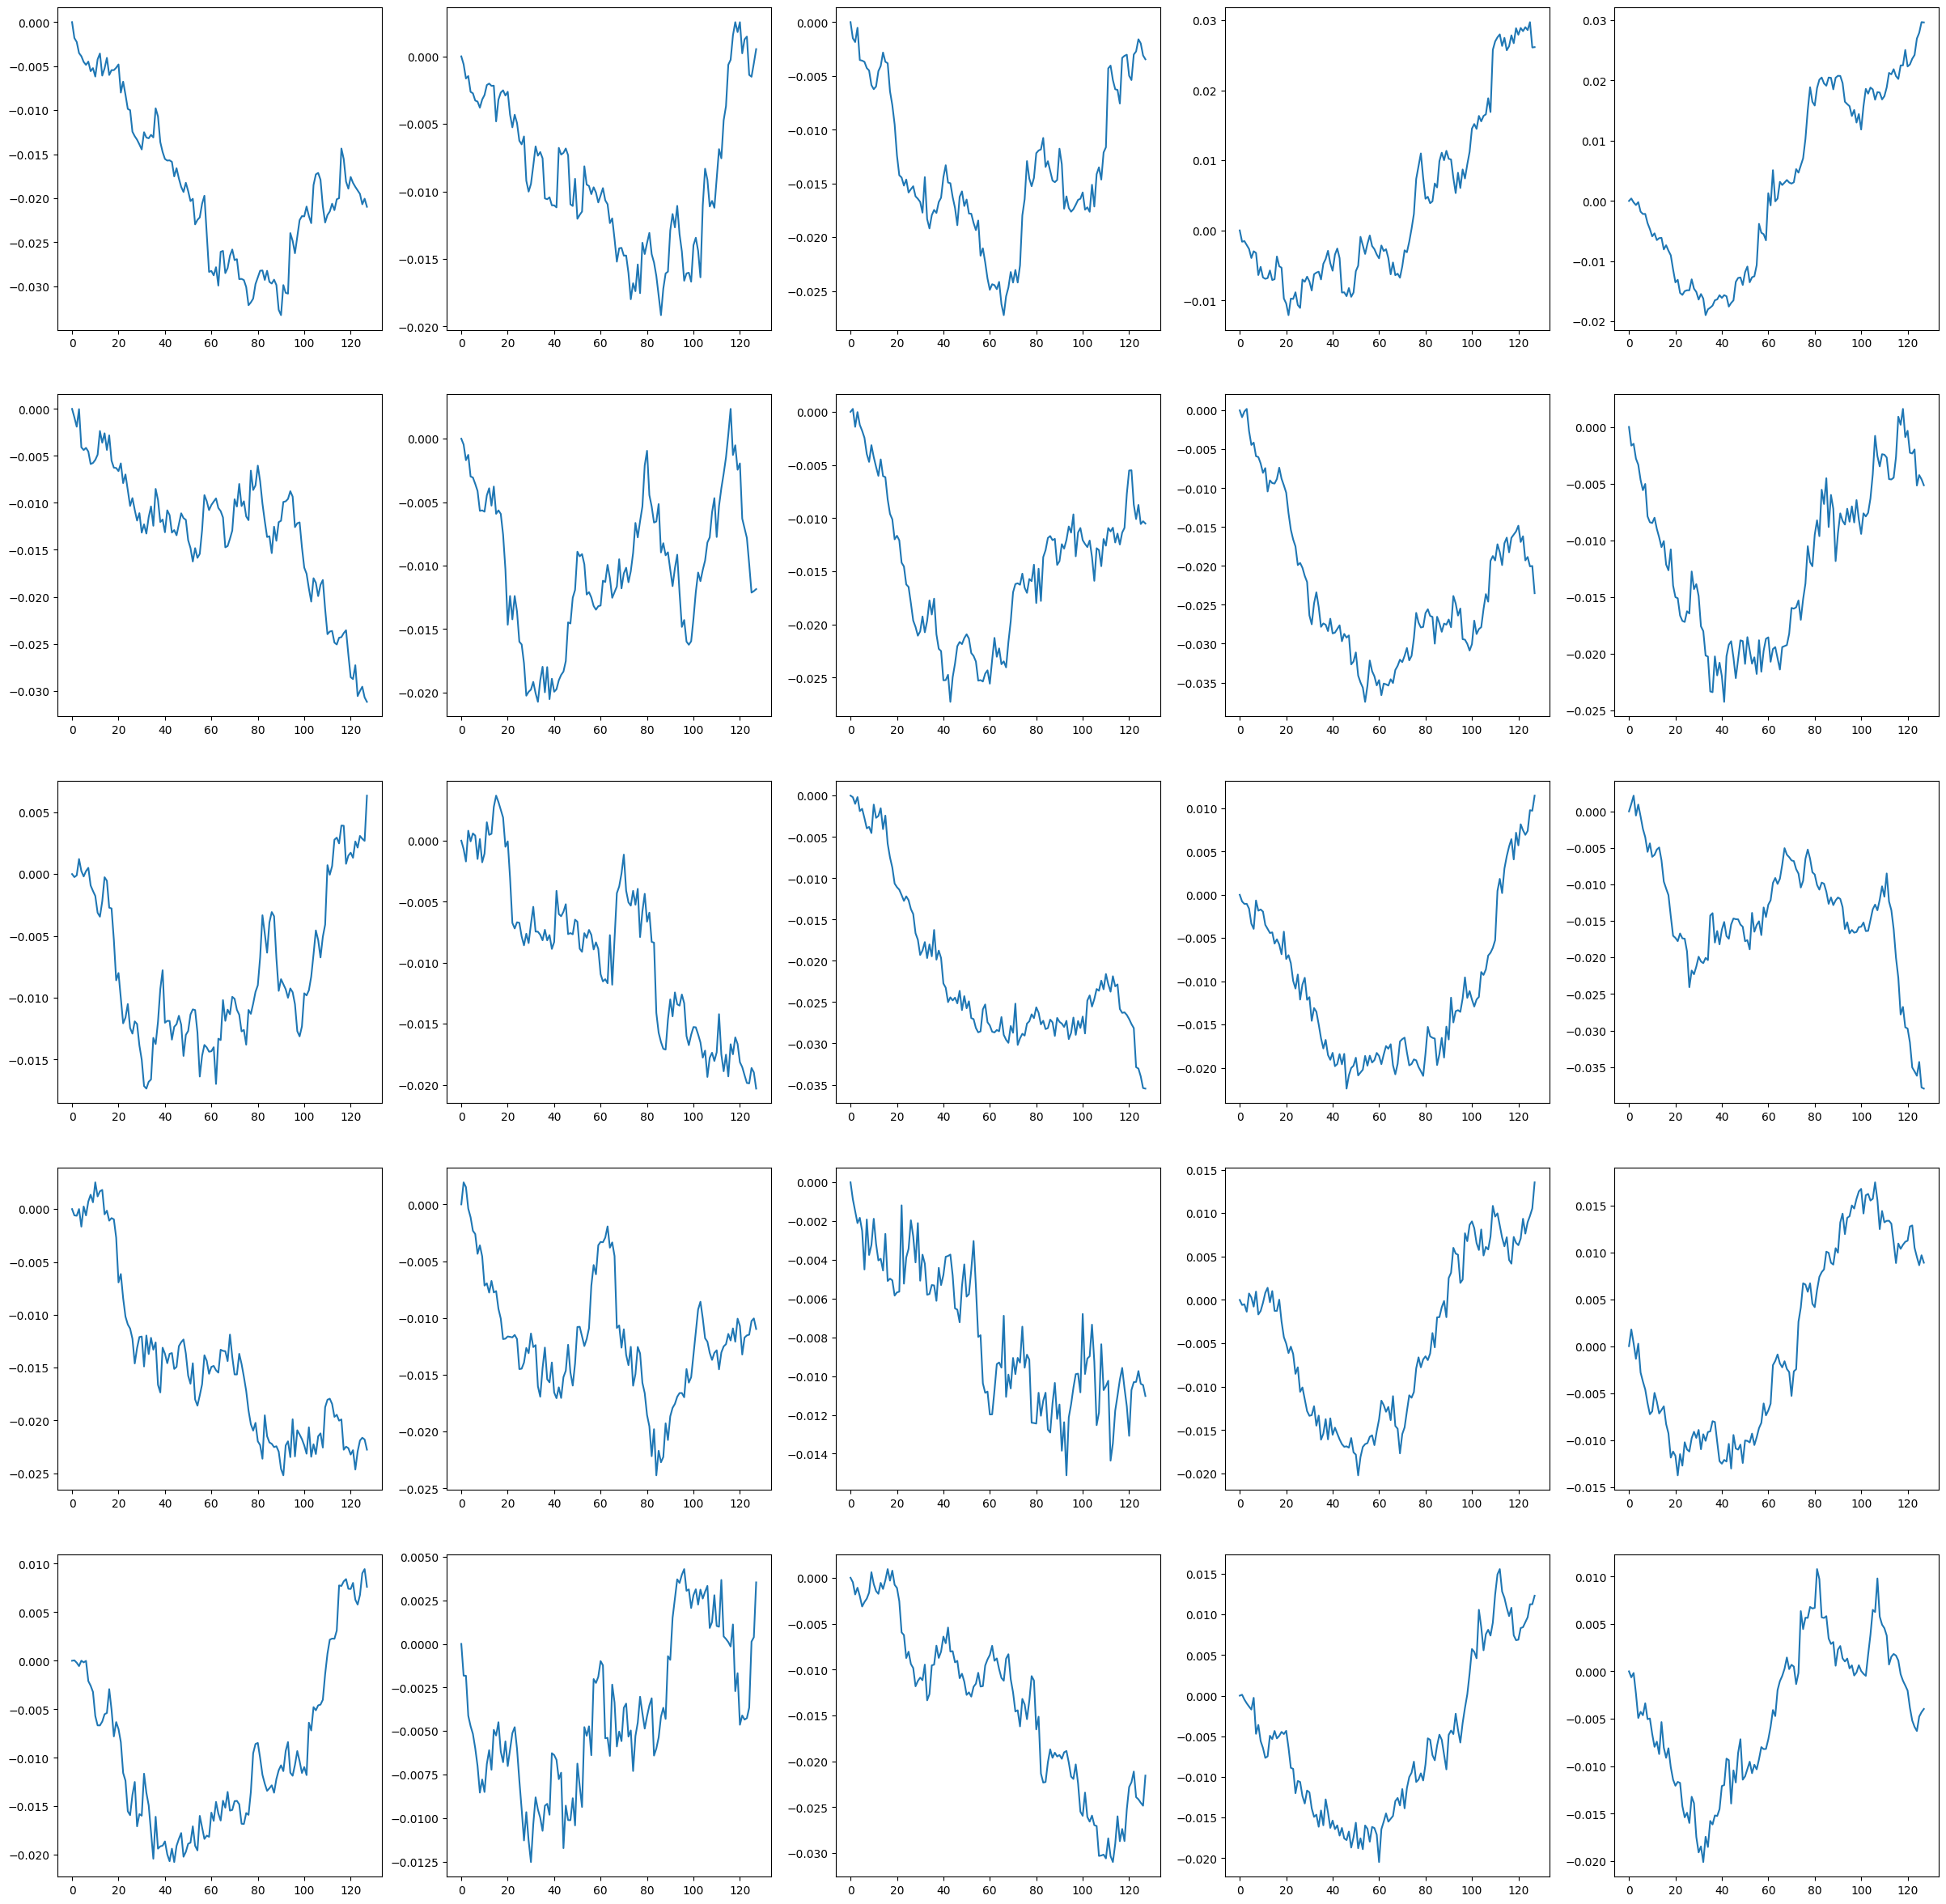

In [280]:
#untrained Generator
G_untrained = Generator()
gen_dt = G_untrained(25, 127)
rev_trf_dt = RevTransform(gen_dt, mean_1, std_1, mean_2, std_2)

plt.figure(figsize=(30, 30))
for i, dt in enumerate(rev_trf_dt):
    plt.subplot(5, 5, i+1)
    plt.plot(dt)
plt.show()

## WGAN with clipping

In [220]:
#If you don't want to waste time on training you can use pretrained WGAN
"""WG_path = r'trained models/WGAN_Clip_G.pth'
WG = Generator()
WG.load_state_dict(torch.load(WG_path))
G = WG"""

"WG_path = r'trained models/WGAN_Generator.pth'\nWG = Generator()\nWG.load_state_dict(torch.load(WG_path))\nG = WG"

In [261]:
#define hyperparameters, initialize Generator, Discriminator and optimizers
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

seq_length = 127 
batch_size = 64
dt_loader = DataLoader(dt_set, batch_size, shuffle=True, drop_last=True)

G_lr = 2e-4
D_lr = 2e-4


c = 0.1 #clipping treshold

G = Generator().to(device)
D = Discriminator(seq_length).to(device) 


G_optm = torch.optim.RMSprop(G.parameters(), lr=G_lr)
D_optm = torch.optim.RMSprop(D.parameters(), lr=D_lr)



Model_losses = []
G_losses = []
D_losses = []


In [271]:
#Train WGAN

n_epochs = 1
step_ratio = 5


with tqdm(total=n_epochs*len(dt_loader), desc=f"Progress") as progress:
    for i in range(n_epochs):
        for i, batch in enumerate(dt_loader):
            
            size = batch.shape[0]
            real_dt = batch.to(device)
            real_dt = batch.to(torch.float32)
            gen_dt = G.forward(size, seq_length).detach()
            D_optm.zero_grad()
            D_l = torch.mean(D(real_dt))
            G_l = torch.mean(D(gen_dt))
            Model_l = -(D_l - G_l)
            Model_l.backward()
            D_optm.step()
            for par in D.parameters():
                par.data.clamp_(-c, c)
            D_losses.append(D_l.item())
            Model_losses.append(-Model_l.item())
        
            if (i+1) % step_ratio == 0:
                G_optm.zero_grad()
                gen_dt = G.forward(size, seq_length)
                G_l = -torch.mean(D(gen_dt))
                G_l.backward()
                G_optm.step()
                for j in range(step_ratio):
                    G_losses.append(-G_l.item())
            progress.update()

Progress:   0%|          | 0/37 [00:00<?, ?it/s]

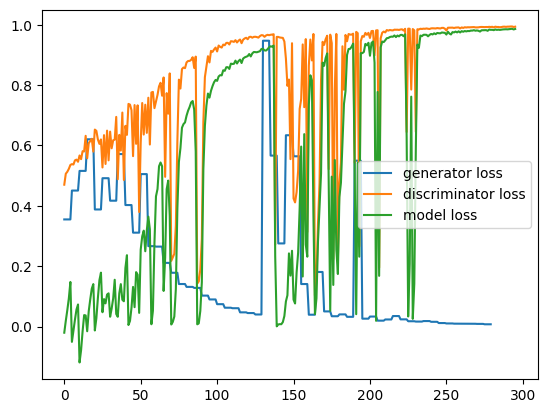

In [272]:
#Plot loss functions for G and D
plt.plot(G_losses, label='generator loss')
plt.plot(D_losses, label='discriminator loss')
plt.plot(Model_losses, label='model loss')
plt.legend()
plt.show()

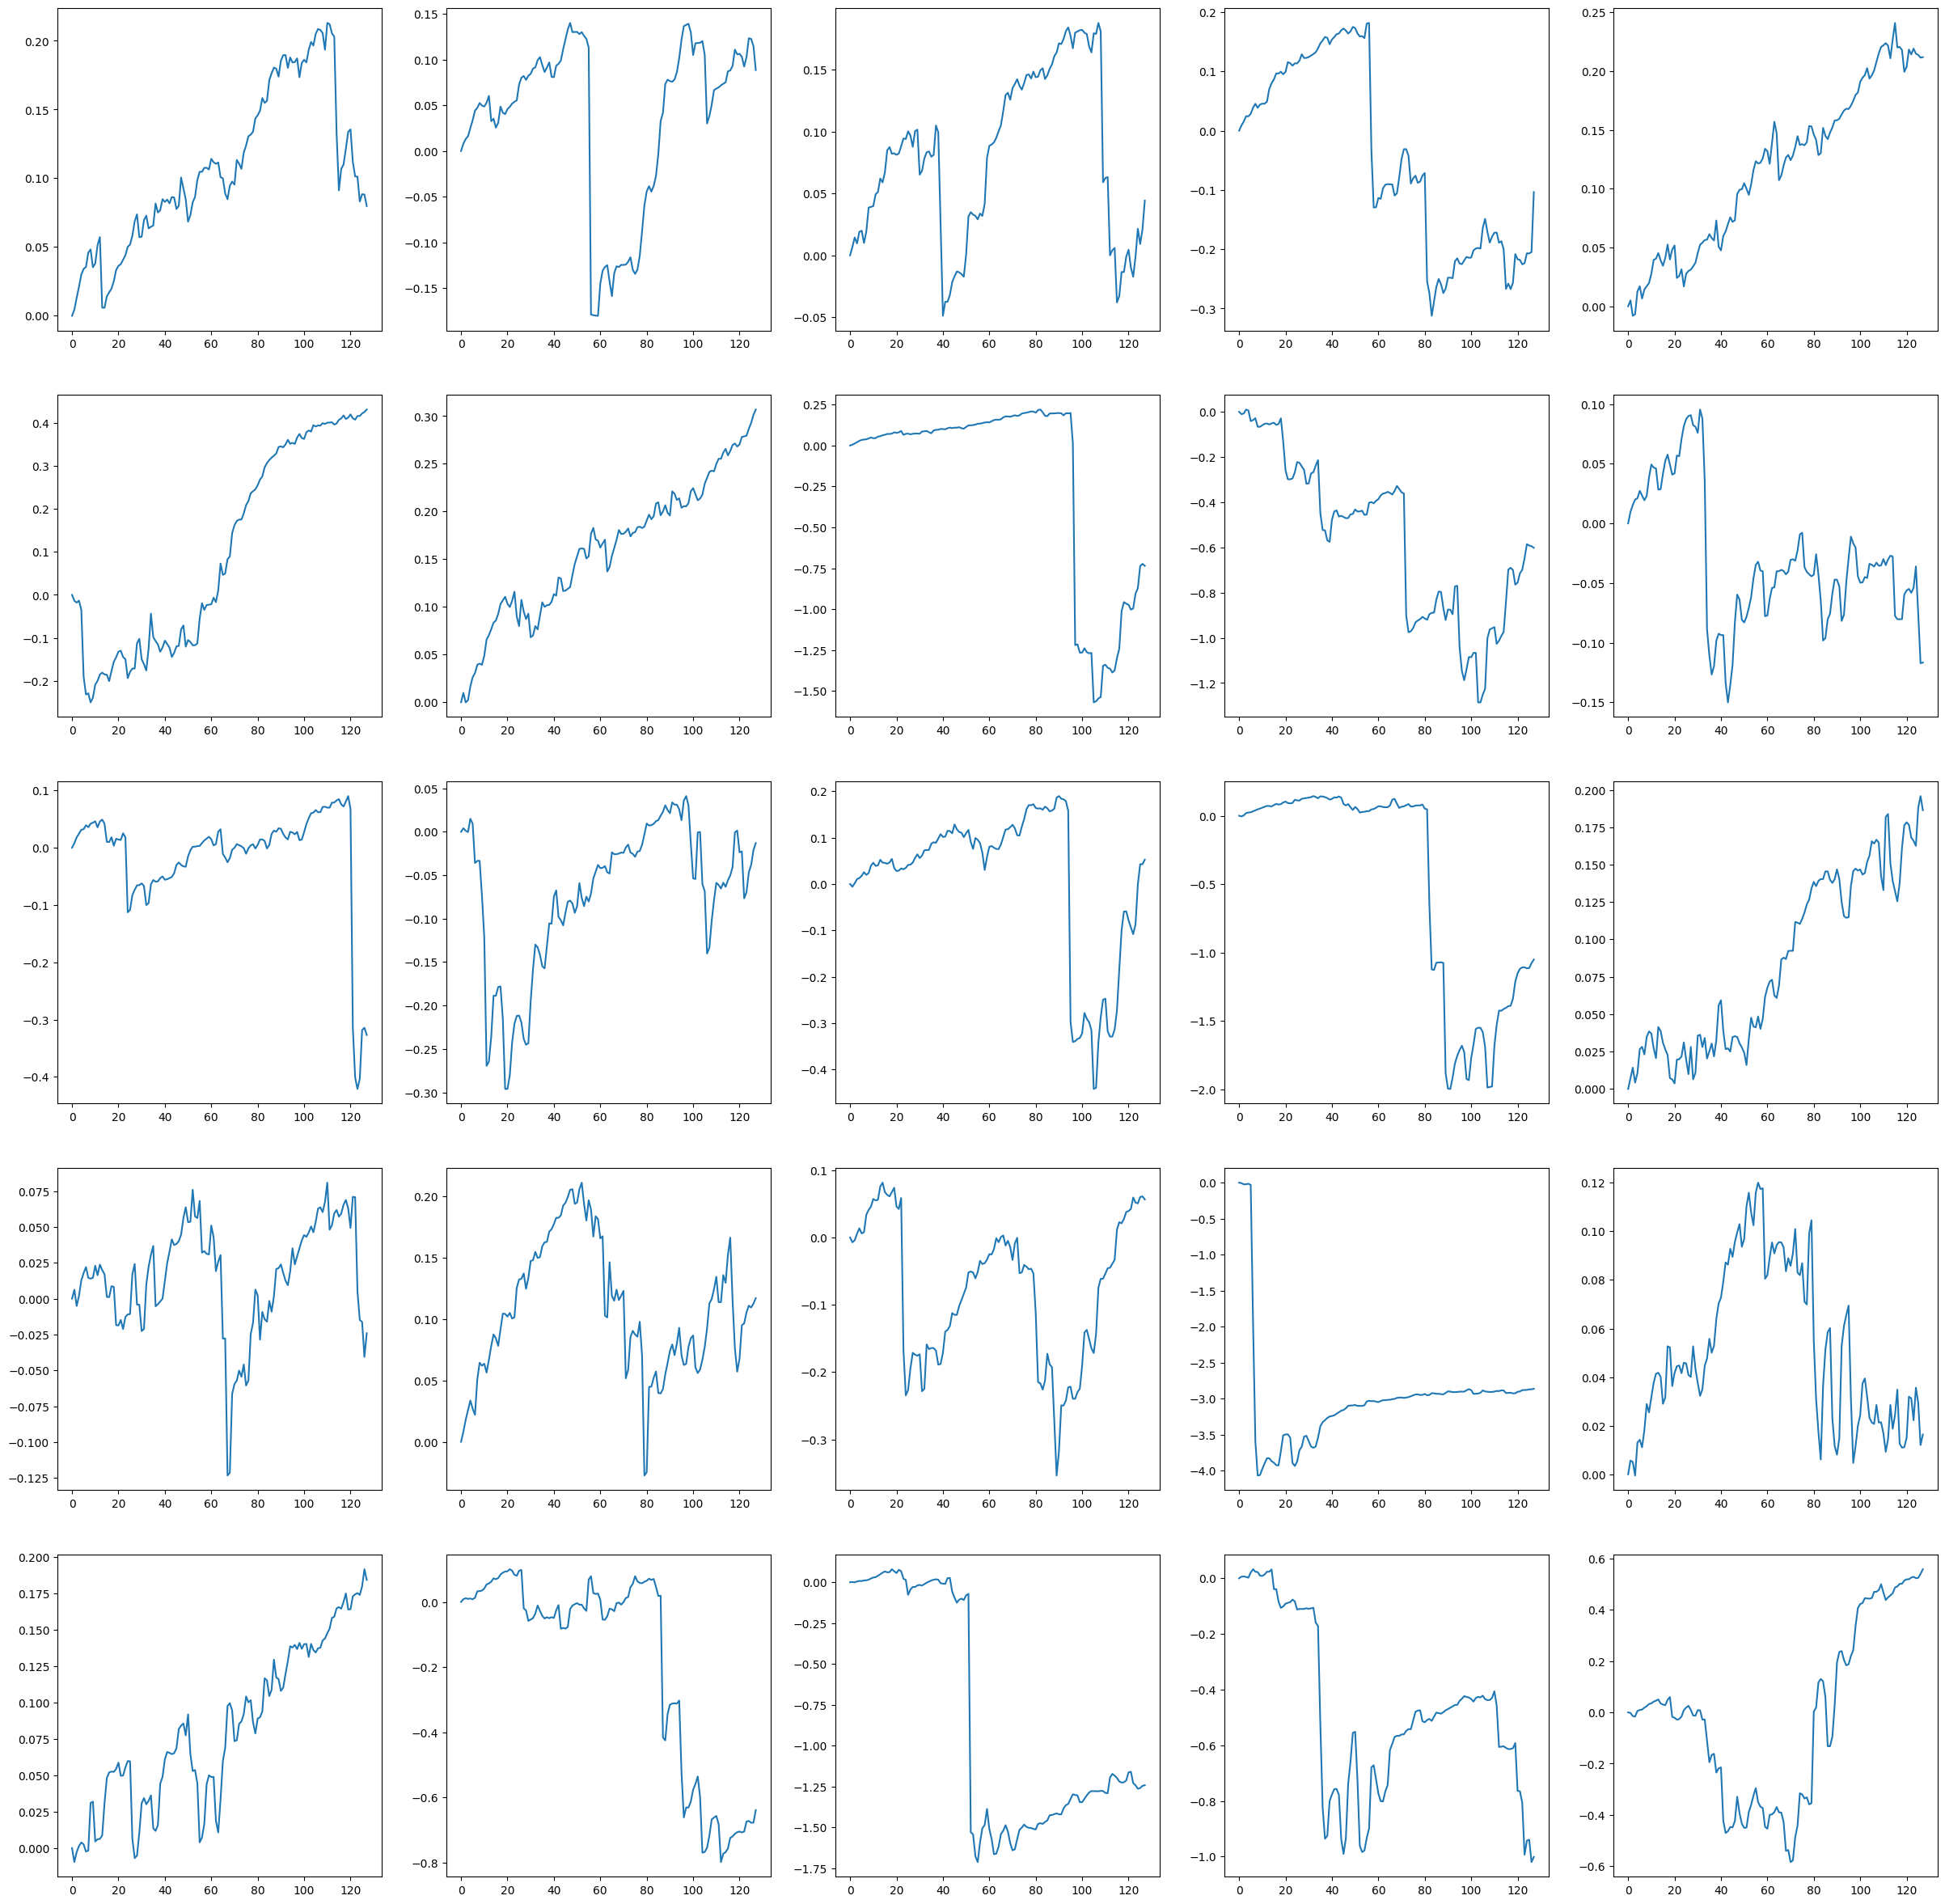

In [273]:
gen_dt = G(25, 127)
rev_trf_dt = RevTransform(gen_dt, mean_1, std_1, mean_2, std_2)

plt.figure(figsize=(30, 30))
for i, dt in enumerate(rev_trf_dt):
    plt.subplot(5, 5, i+1)
    plt.plot(dt)
plt.show()

In [274]:
#save G and D for WGAN
G_path = r'trained models/WGAN_Clip_G.pth'
D_path = r'trained models/WGAN_Clip_D.pth'
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)

WGAN with clipping doesn't produce very good time-series, but at least something more or less realistic. And result don't look similar to random noise, unlike in the case of Vanilla GAN. 

## WGAN with Gradient Penalty

In [ ]:
#If you don't want to waste time on training you can use pretrained WGAN
"""WG_GP_path = r'trained models/WGAN_GP_G.pth'
WG_GP = Generator()
WG_GP.load_state_dict(torch.load(WG_path))
G = WG_GP"""

In [296]:
def gradient_penalty(D, real_dt, gen_dt, device):
    """Calculates the gradient penalty loss for WGAN GP"""

    size = real_dt.shape[0]
    n_ch = real_dt.shape[1]
    seq_length = real_dt.shape[2]
    
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((size, 1, 1), device=device)
    
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_dt + ((1 - alpha) * gen_dt)).requires_grad_(True)
    interpolates = interpolates.to(torch.float32)
    d_interpolates = D(interpolates)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates), # gradients w.t. output. 1 is default
        create_graph=True,
        retain_graph=True, # keep all gradients for further optimization steps
    )[0]

    gradients = gradients.view(size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [357]:
#define hyperparameters, initialize Generator, Discriminator and optimizers
device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'

seq_length = 127 
batch_size = 64
dt_loader = DataLoader(dt_set, batch_size, shuffle=True, drop_last=True)

G_lr = 2e-4
D_lr = 2e-4

k = 0.0001 #penalty coefficient

G = Generator().to(device)
D = Discriminator(seq_length).to(device) 

G_optm = torch.optim.RMSprop(G.parameters(), lr=G_lr)
D_optm = torch.optim.RMSprop(D.parameters(), lr=D_lr)


Model_losses = []
G_losses = []
D_losses = []


In [367]:
#Train WGAN

n_epochs = 5
step_ratio = 5


with tqdm(total=n_epochs*len(dt_loader), desc=f"Progress") as progress:
    for i in range(n_epochs):
        for i, batch in enumerate(dt_loader):
            
            size = batch.shape[0]
            real_dt = batch.to(device)
            real_dt = batch.to(torch.float32)
            gen_dt = G.forward(size, seq_length).detach()
            D_optm.zero_grad()
            D_l = torch.mean(D(real_dt))
            G_l = torch.mean(D(gen_dt))
            penalty = gradient_penalty(D, real_dt, gen_dt, device)
            G_l = G_l.detach()
            Model_l = -(D_l - G_l + k*penalty)
            Model_l.backward()
            D_optm.step()
            D_losses.append(D_l.item())
            Model_losses.append(-Model_l.item())
        
            if (i+1) % step_ratio == 0:
                gen_dt = G.forward(size, seq_length)
                G_optm.zero_grad()
                G_l = -torch.mean(D(gen_dt))
                G_l.backward()
                G_optm.step()
                #torch.nn.utils.clip_grad_norm_(G.parameters(), 1)
                for j in range(step_ratio):
                    G_losses.append(-G_l.item())
            progress.update()

Progress:   0%|          | 0/185 [00:00<?, ?it/s]

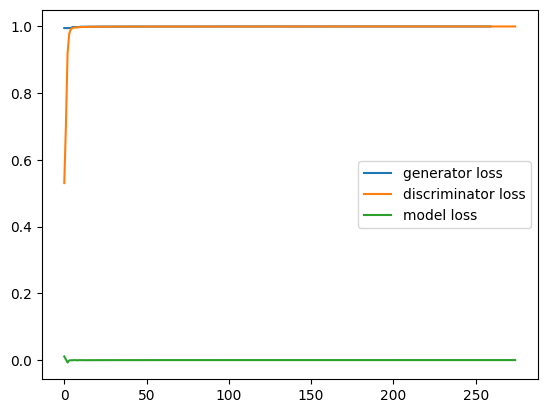

In [370]:
#Plot loss functions for G and D
plt.plot(G_losses, label='generator loss')
plt.plot(D_losses, label='discriminator loss')
plt.plot(Model_losses, label='model loss')
plt.legend()
plt.show()

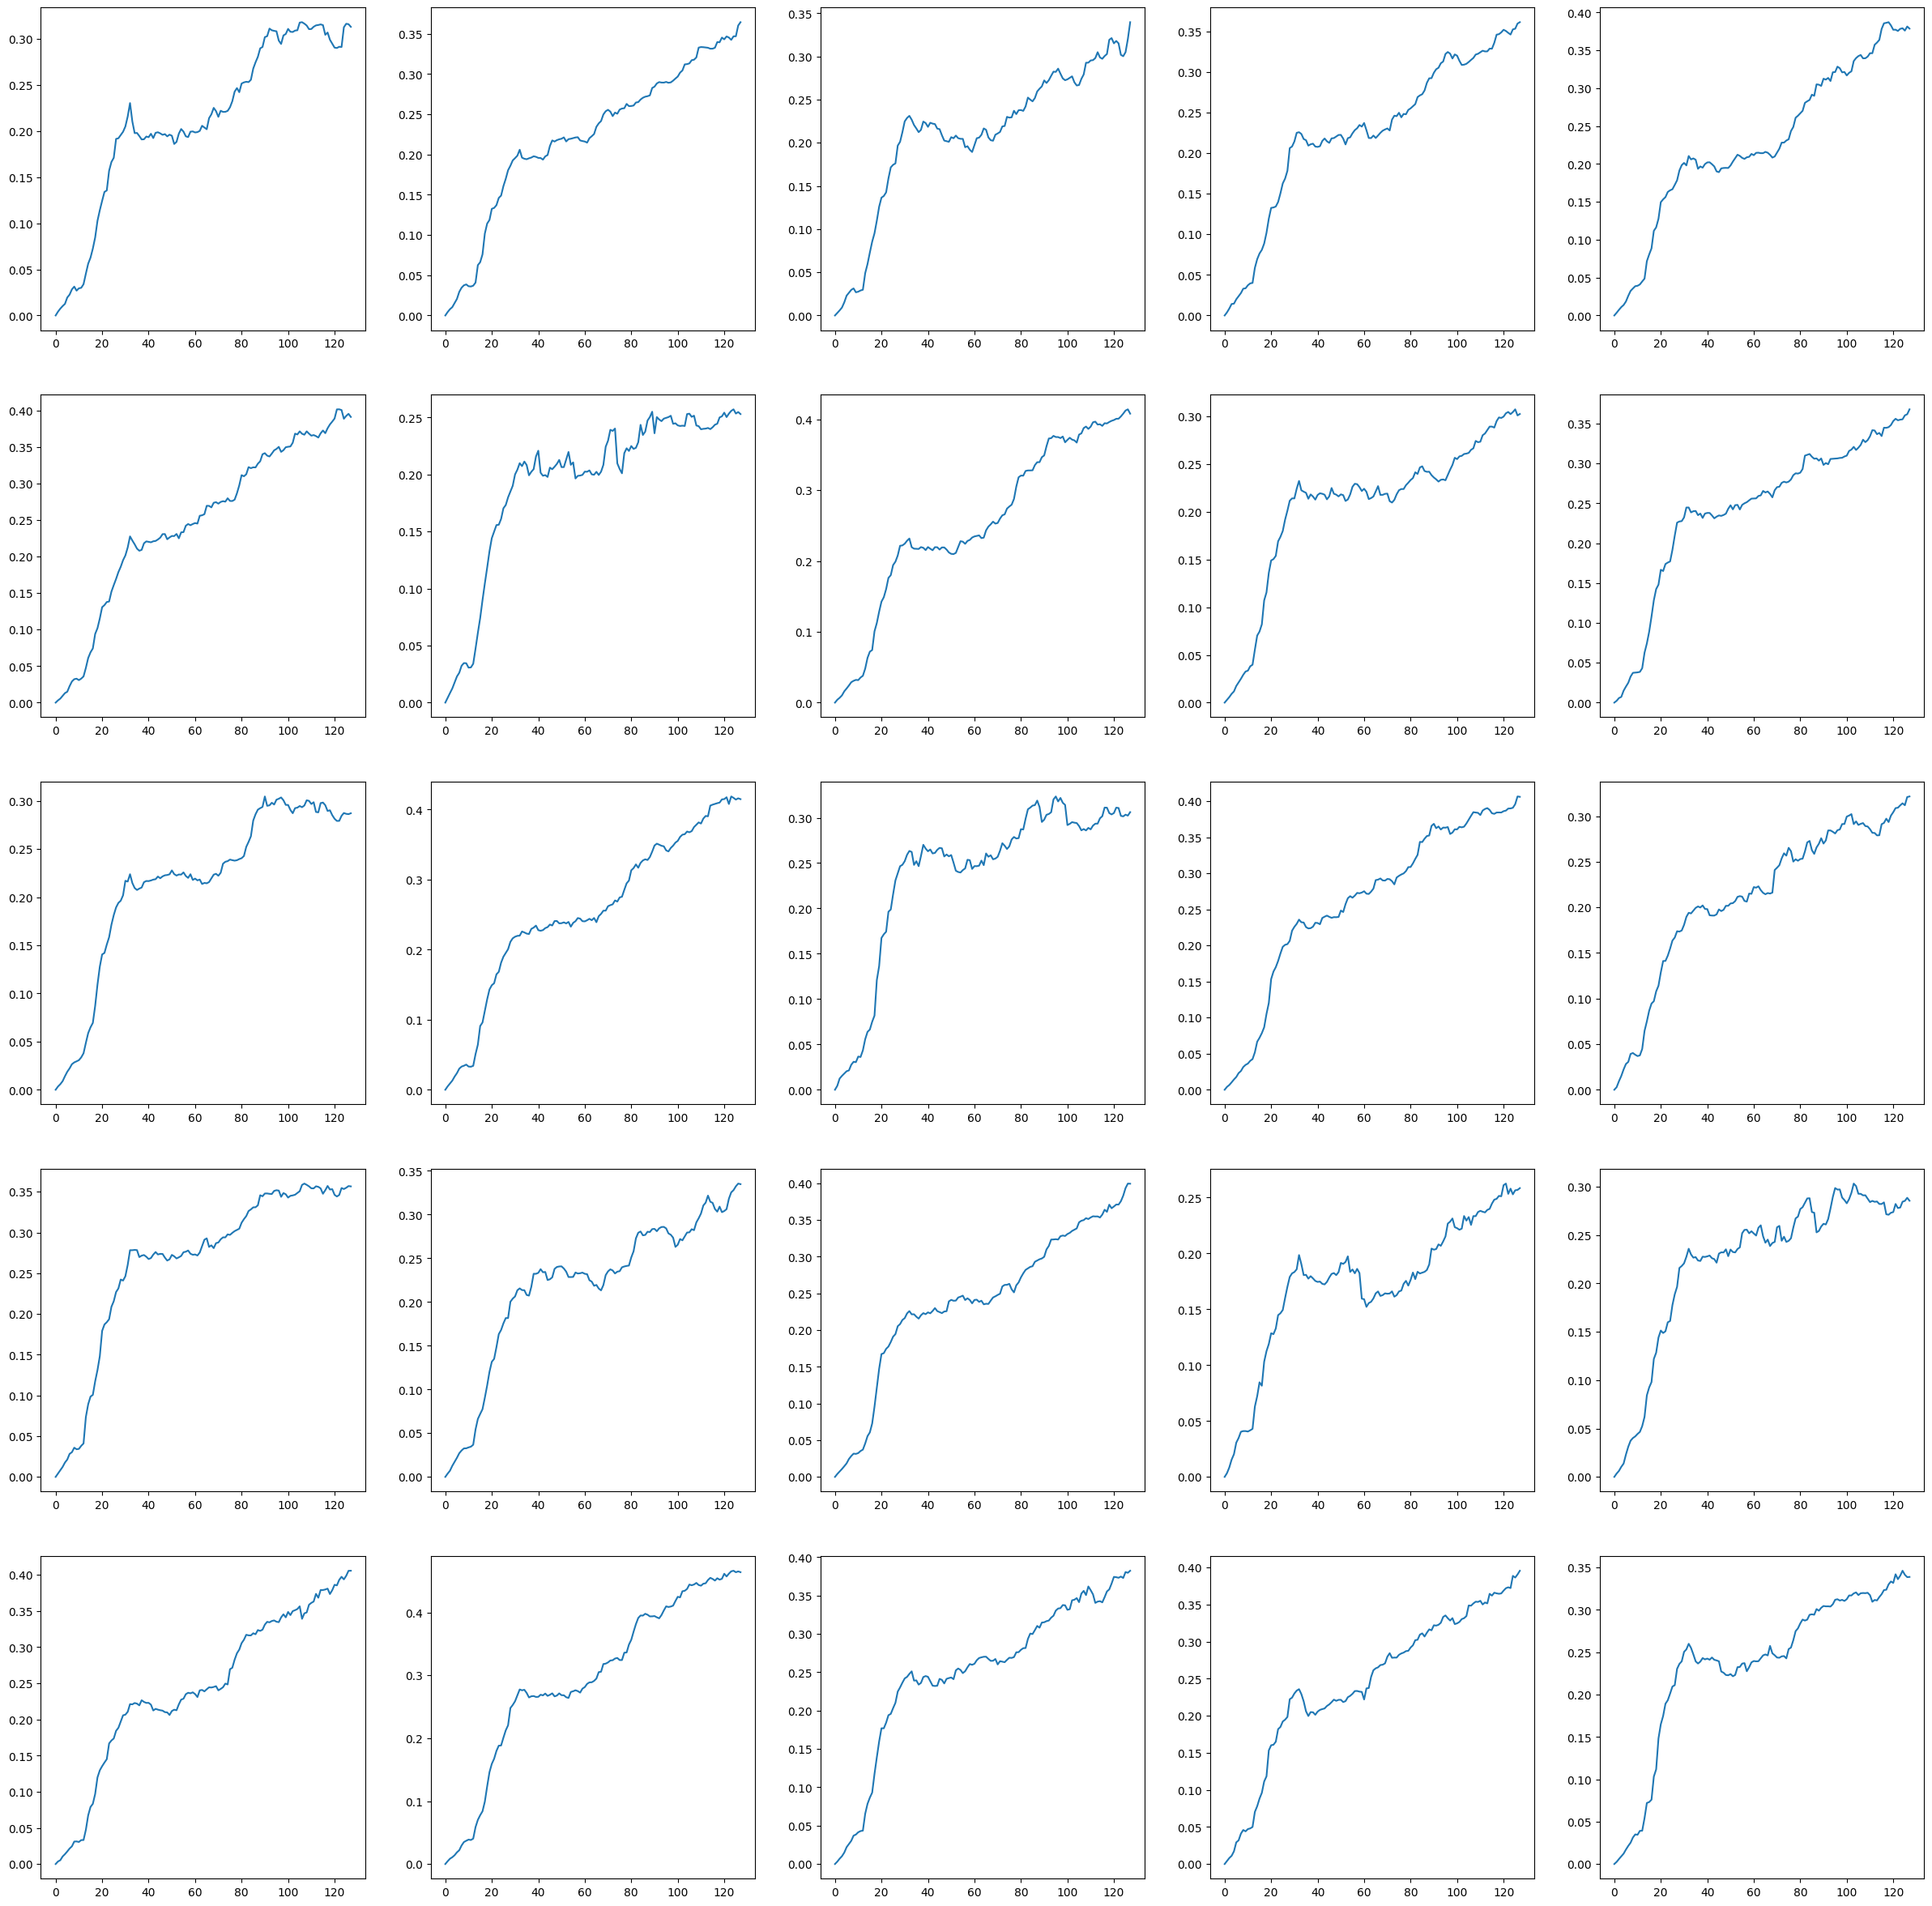

In [371]:
gen_dt = G(25, 127)
rev_trf_dt = RevTransform(gen_dt, mean_1, std_1, mean_2, std_2)

plt.figure(figsize=(30, 30))
for i, dt in enumerate(rev_trf_dt):
    plt.subplot(5, 5, i+1)
    plt.plot(dt)
plt.show()

In [373]:
#save G and D for WGAN
G_path = r'trained models/WGAN_GP_G.pth'
D_path = r'trained models/WGAN_GP_D.pth'
torch.save(G.state_dict(), G_path)
torch.save(D.state_dict(), D_path)

We can see from the plots above that loss functions WGAN GP behave rather strage, also produced time-serise are prone to mode collaps. Potentially it is possible to finde better configuration by performing more precise hyperparameters tunning. 

### Real samples

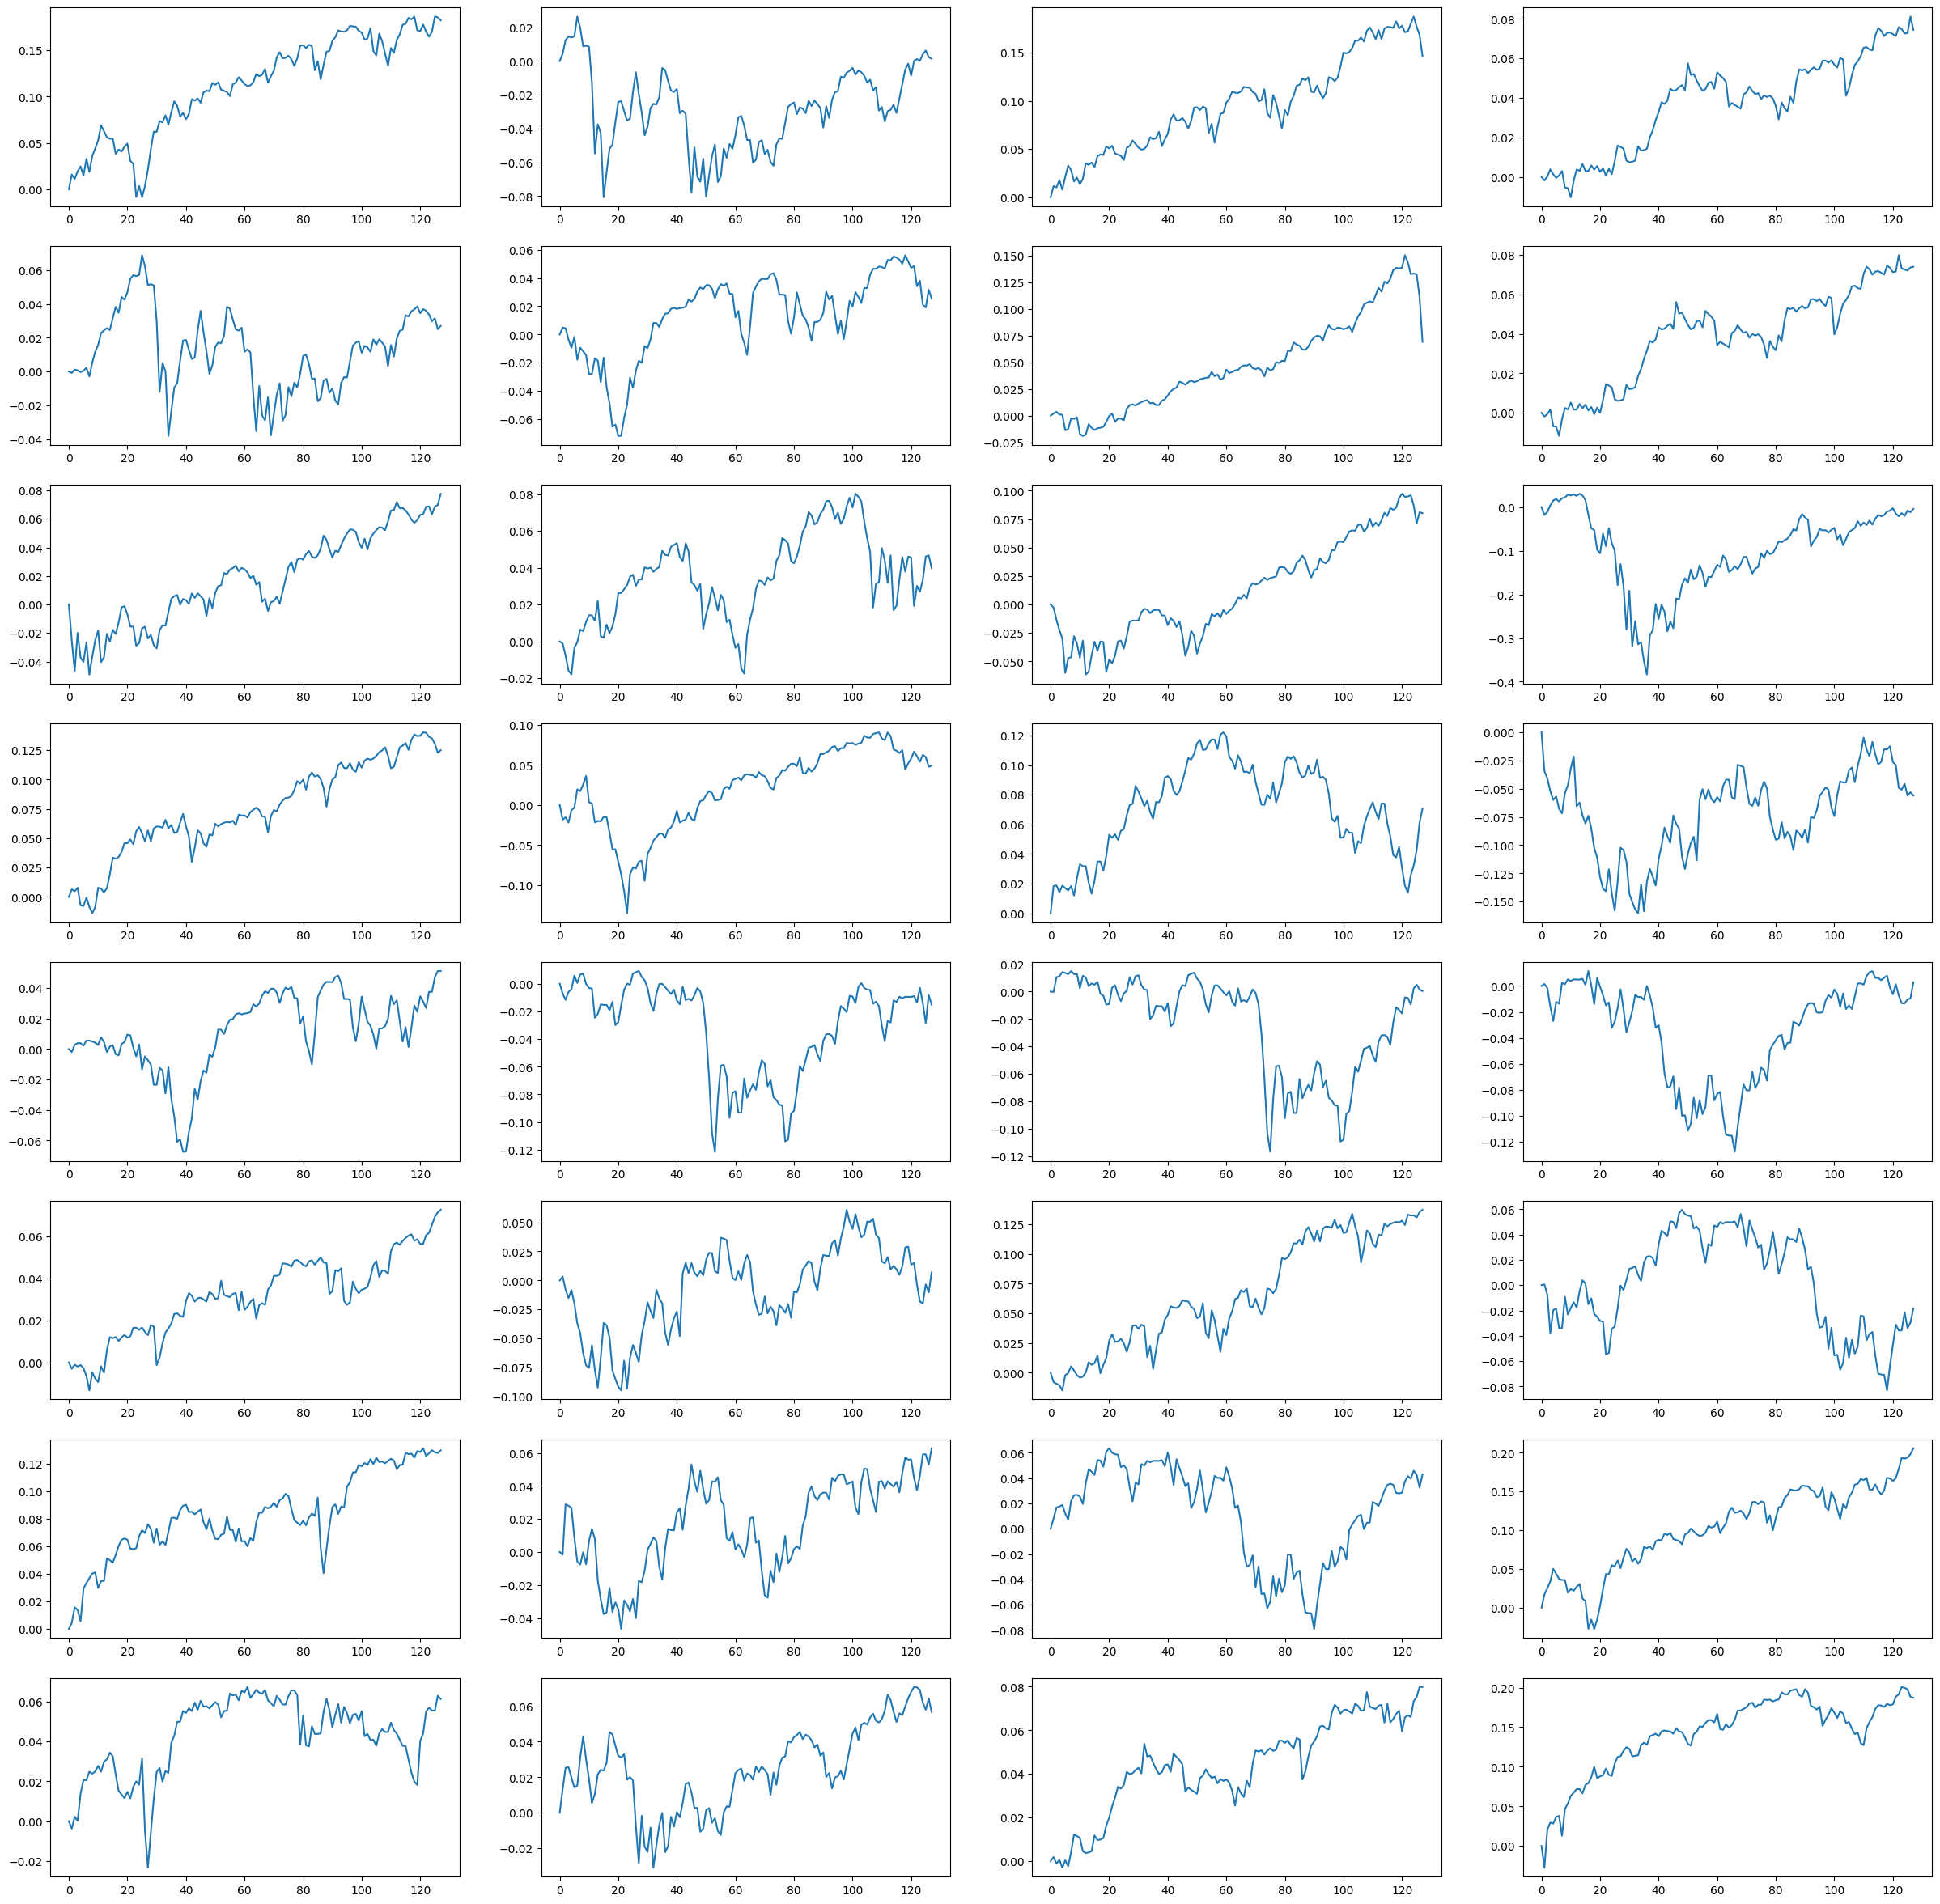

In [200]:
#Some real samples for comparing with generated ones
for batch in dt_loader:
    break
rev_trf_dt = RevTransform(batch, mean_1, std_1, mean_2, std_2)

plt.figure(figsize=(30, 30))
for i, dt in enumerate(rev_trf_dt):
    plt.subplot(8, 4, i+1)
    plt.plot(dt)
plt.show()

## Conclusion

Neither of our models has learned to generate realistic time-series, however WGAN with clipping seems to be the most promissing one. So better training of the mentioned model could potentially lead to far better results.

## Density Functions

In [385]:
#Download pretrained models
VG_path = r'trained models/Vanilla_GAN_G.pth'
WG_Clip_path = r'trained models/WGAN_Clip_G.pth'
WG_GP_path = r'trained models/WGAN_GP_G.pth'
VG = Generator()
WG_Clip = Generator()
WG_GP = Generator()

VG.load_state_dict(torch.load(VG_path))
WG_Clip.load_state_dict(torch.load(WG_Clip_path))
WG_GP.load_state_dict(torch.load(WG_GP_path))

<All keys matched successfully>

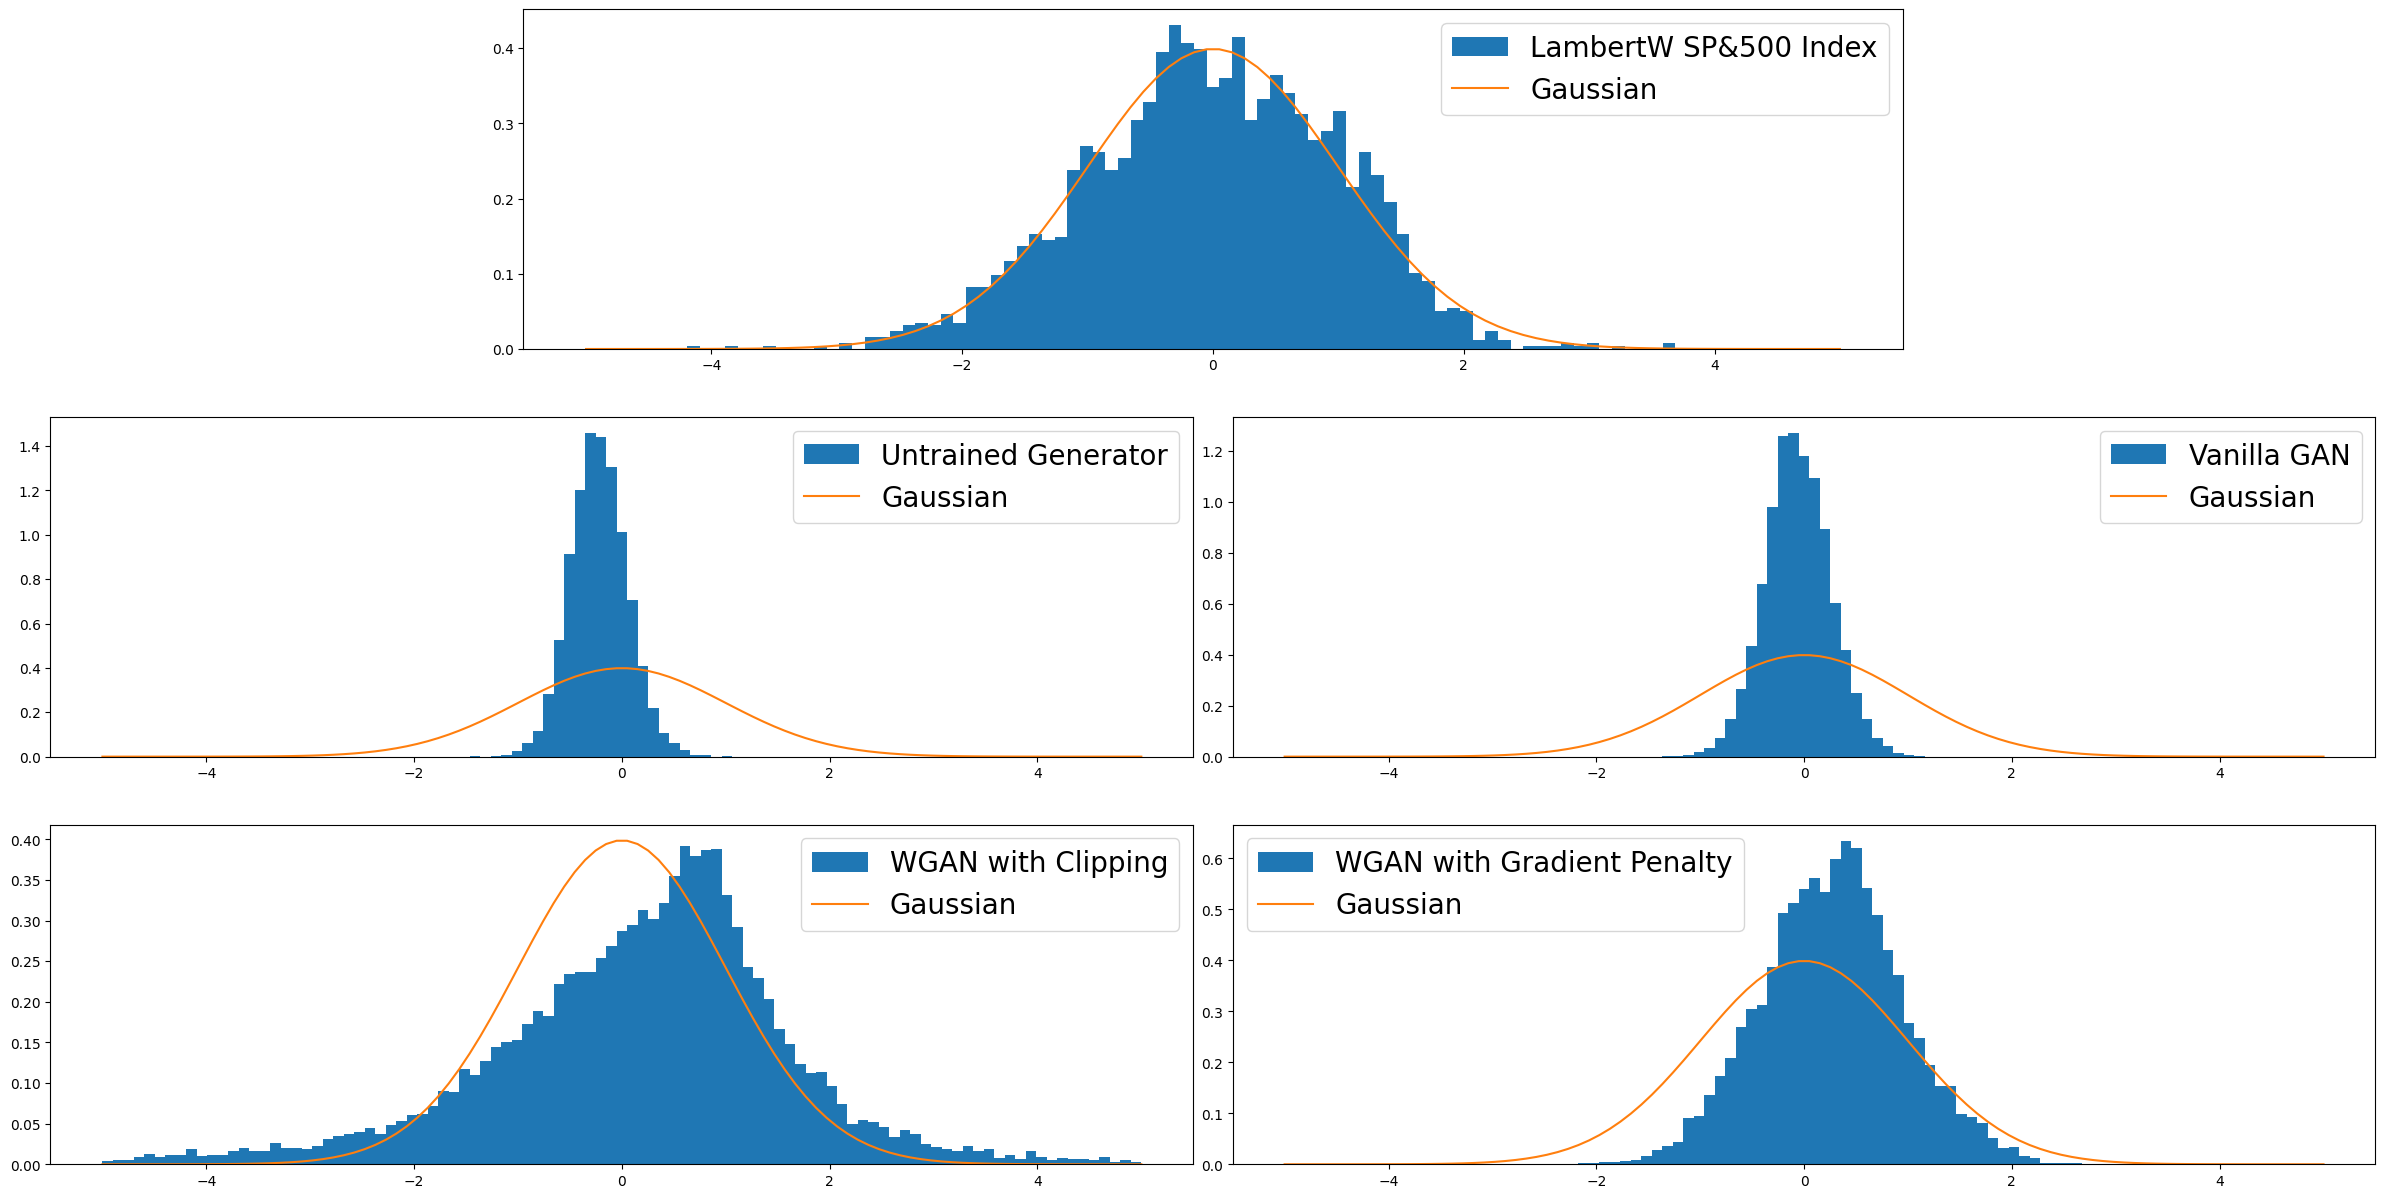

In [420]:
#plot density functions for real data, Gaussian, VG, WGAN_Clip, WGAN_GP
bins = np.linspace(-5, 5, 100)
gaussian = [norm.pdf(i) for i in bins]

plt.figure(figsize=(30, 15))

plt.subplot(3, 10, (3,8))

x = df.to_numpy().reshape(-1)
label = 'LambertW SP&500 Index'

plt.hist(x, bins, label= label, density=True)
plt.plot(bins, gaussian, label = 'Gaussian')
plt.legend(fontsize = 20)

plt.subplot(3, 10, (11,15))

G = Generator()
x = G(100, 127).view(-1).detach().numpy()
label = 'Untrained Generator'

plt.hist(x, bins, label= label, density=True)
plt.plot(bins, gaussian, label = 'Gaussian')
plt.legend(fontsize = 20)

plt.subplot(3, 10, (16,20))

x = VG(100, 127).view(-1).detach().numpy()
label = 'Vanilla GAN'

plt.hist(x, bins, label= label, density=True)
plt.plot(bins, gaussian, label = 'Gaussian')
plt.legend(fontsize = 20)

plt.subplot(3, 10, (21,25))

x =  WG_Clip(100, 127).view(-1).detach().numpy()
label = 'WGAN with Clipping'

plt.hist(x, bins, label= label, density=True)
plt.plot(bins, gaussian, label = 'Gaussian')
plt.legend(fontsize = 20)

plt.subplot(3, 10, (26,30))

x = WG_GP(100, 127).view(-1).detach().numpy()
label = 'WGAN with Gradient Penalty'

plt.hist(x, bins, label= label, density=True)
plt.plot(bins, gaussian, label = 'Gaussian')
plt.legend(fontsize = 20)

plt.show()

Plots above comfirm previously mentioned observations
1. Vanilla GAN isn't better than untrained model
2. WGAN with clipping shows the best performance

## Conclusions

Neither of our models has learned to generate realistic time-series, however WGAN with clipping seems to be the most promissing one. So better training of the mentioned model could potentially lead to far better results.